In [299]:
import colorcet as cc
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pyolim

from skimage.transform import rescale

# Load and scale Marmousi velocity model

The Marmousi model stores a velocity in [m/s]. The model is 9.2km long and 3km deep.

In [2]:
with np.load('marmousi.npz') as data:
    F = data['F']

Convert to [km/s].

In [3]:
F /= 1000

Define Z and X coordinates in [m]

In [92]:
xmin, xmax, nx = 0.0, 9.2, F.shape[1]
zmin, zmax, nz = 0.0, 3.0, F.shape[0]
X, Z = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(zmin, zmax, nz))

Plot model with units (recreate plot from [here](http://www.reproducibility.org/RSF/book/data/marmousi/paper_html/node2.html))

In [123]:
figsize = (14, 4) # We'll use this size below, so store it here
cmap = cc.cm.bmy # Pick a nice colormap

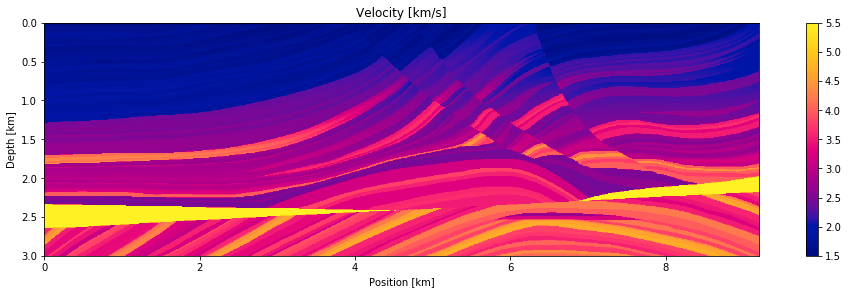

In [124]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.imshow(F, cmap=cmap, extent=[xmin, xmax, zmax, zmin])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_aspect('equal')
ax.set_title('Velocity [km/s]')
fig.colorbar(im, ax=ax)
fig.tight_layout()

# Upsample and downsample

In [13]:
bigger_levels, smaller_levels = 3, 3
Fs = [F]

print('- upsampling')
for l in range(bigger_levels):
    Fs.append(rescale(Fs[-1], 2, mode='constant', multichannel=False))
Fs = list(reversed(Fs))
print('- downsampling')
for l in range(smaller_levels):
    Fs.append(rescale(Fs[-1], 0.5, mode='constant', multichannel=False))
Fs = list(reversed(Fs))

In [16]:
levels = len(Fs)
for level in range(levels):
    print('level %d: shape = %s' % (level, Fs[level].shape))

level 0: shape = (94, 288)
level 1: shape = (188, 575)
level 2: shape = (376, 1150)
level 3: shape = (751, 2301)
level 4: shape = (1502, 4602)
level 5: shape = (3004, 9204)
level 6: shape = (6008, 18408)


# Convert to slowness for use with `pyolim`

In [20]:
Ss = [1/F for F in Fs]

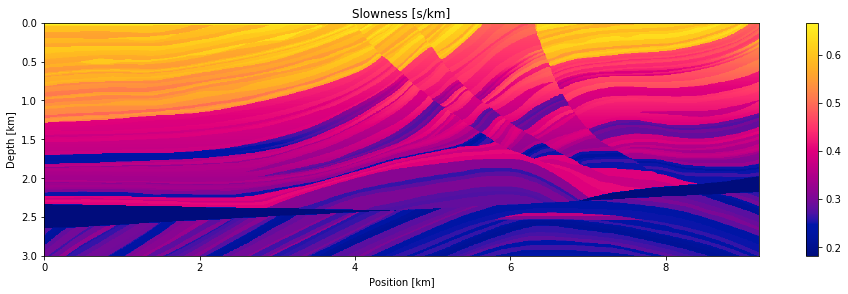

In [108]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.imshow(Ss[3], cmap=cmap, extent=[xmin, xmax, zmax, zmin])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_aspect('equal')
ax.set_title('Slowness [s/km]')
fig.colorbar(im, ax=ax)
fig.tight_layout()

# Solve some test problems

In [118]:
level = 2
S = Ss[level]
nz, nx = S.shape
X, Z = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(zmin, zmax, nz))
h = zmax/(nz - 1)

### Compute first arrival times for a single point source

In [127]:
nb = pyolim.Neighborhood.OLIM8
quad = pyolim.Quadrature.MP0
olim = pyolim.Olim(nb, quad, S, h)
olim.add_src((0, 0))
olim.solve()

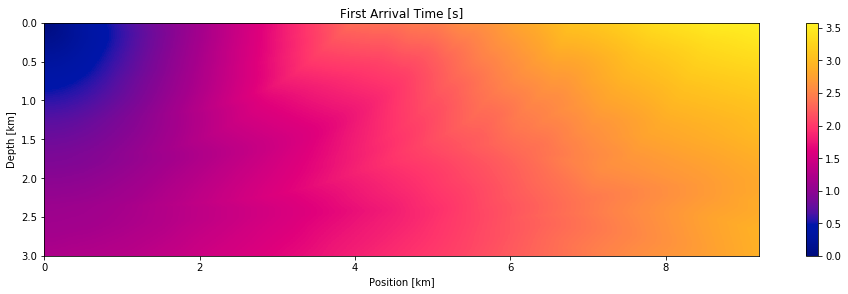

In [120]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.imshow(olim.U, cmap=cmap, extent=[xmin, xmax, zmax, zmin])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_title('First Arrival Time [s]')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
fig.tight_layout()

### Compute first arrival times from the surface

In [121]:
nb = pyolim.Neighborhood.OLIM8
quad = pyolim.Quadrature.MP0
olim = pyolim.Olim(nb, quad, S, h)
for j in range(nx):
    olim.add_src((0, j))
olim.solve()

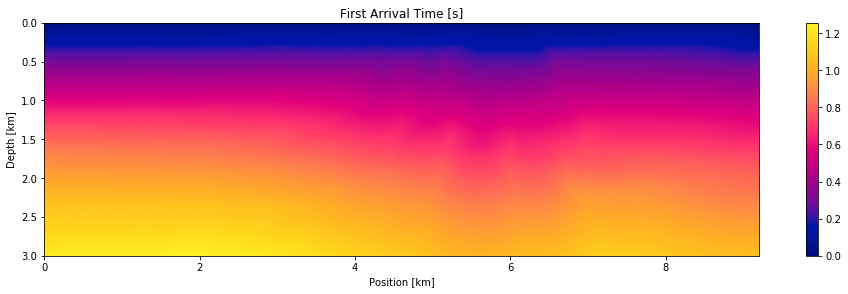

In [125]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.imshow(olim.U, cmap=cmap, extent=[xmin, xmax, zmax, zmin])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_title('First Arrival Time [s]')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
fig.tight_layout()

# Make some convergence plots

Start by solving a problem at the original (largest) size using `olim8_mp0`.

In [262]:
S = Ss[-1]
nz, nx = S.shape
X, Z = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(zmin, zmax, nz))
h = zmax/(nz - 1)

nb = pyolim.Neighborhood.OLIM8
quad = pyolim.Quadrature.MP0

olim = pyolim.Olim(nb, quad, S, h)
for j in range(nx):
    olim.add_src((0, j))
olim.solve()

u = olim.U.copy()

Downsample the original problem to all other problem sizes.

In [275]:
us = [
    rescale(u, 2**-l, mode='constant', multichannel=False)
    for l in range(len(Ss) - 1, -1, -1)
]

Define functions to compute $U$ for a given neighborhood, quadrature, and problem size (`l`).

In [280]:
def get_U(nb, quad, l):
    S = Ss[l]
    nz, nx = S.shape
    X, Z = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(zmin, zmax, nz))
    h = zmax/(nz - 1)

    olim = pyolim.Olim(nb, quad, S, h)
    for j in range(nx):
        olim.add_src((0, j))
    olim.solve()
    
    return olim.U.copy()

Compute $U$ for all neighboorhood, quadrature rule, and size combinations.

In [300]:
nbs = [pyolim.Neighborhood.OLIM4, pyolim.Neighborhood.OLIM8]
quads = [pyolim.Quadrature.MP0, pyolim.Quadrature.MP1, pyolim.Quadrature.RHR]
E = dict()
for nb, quad, l in it.product(nbs, quads, range(len(us))):
    print(nb, quad, l)
    E[nb, quad, l] = get_U(nb, quad, l) - us[l]

Neighborhood.OLIM4 Quadrature.MP0 0
Neighborhood.OLIM4 Quadrature.MP0 1
Neighborhood.OLIM4 Quadrature.MP0 2
Neighborhood.OLIM4 Quadrature.MP0 3
Neighborhood.OLIM4 Quadrature.MP0 4
Neighborhood.OLIM4 Quadrature.MP0 5
Neighborhood.OLIM4 Quadrature.MP0 6
Neighborhood.OLIM4 Quadrature.MP1 0
Neighborhood.OLIM4 Quadrature.MP1 1
Neighborhood.OLIM4 Quadrature.MP1 2
Neighborhood.OLIM4 Quadrature.MP1 3
Neighborhood.OLIM4 Quadrature.MP1 4
Neighborhood.OLIM4 Quadrature.MP1 5
Neighborhood.OLIM4 Quadrature.MP1 6
Neighborhood.OLIM4 Quadrature.RHR 0
Neighborhood.OLIM4 Quadrature.RHR 1
Neighborhood.OLIM4 Quadrature.RHR 2
Neighborhood.OLIM4 Quadrature.RHR 3
Neighborhood.OLIM4 Quadrature.RHR 4
Neighborhood.OLIM4 Quadrature.RHR 5
Neighborhood.OLIM4 Quadrature.RHR 6
Neighborhood.OLIM8 Quadrature.MP0 0
Neighborhood.OLIM8 Quadrature.MP0 1
Neighborhood.OLIM8 Quadrature.MP0 2
Neighborhood.OLIM8 Quadrature.MP0 3
Neighborhood.OLIM8 Quadrature.MP0 4
Neighborhood.OLIM8 Quadrature.MP0 5
Neighborhood.OLIM8 Quadratur

Less typing...

In [303]:
nb2str = {
    pyolim.Neighborhood.OLIM4: 'olim4',
    pyolim.Neighborhood.OLIM8: 'olim8'
}
quad2str = {
    pyolim.Quadrature.MP0: 'mp0',
    pyolim.Quadrature.MP1: 'mp1',
    pyolim.Quadrature.RHR: 'rhr',
}

Make plot of error (`err`) vs problem size (`N`)

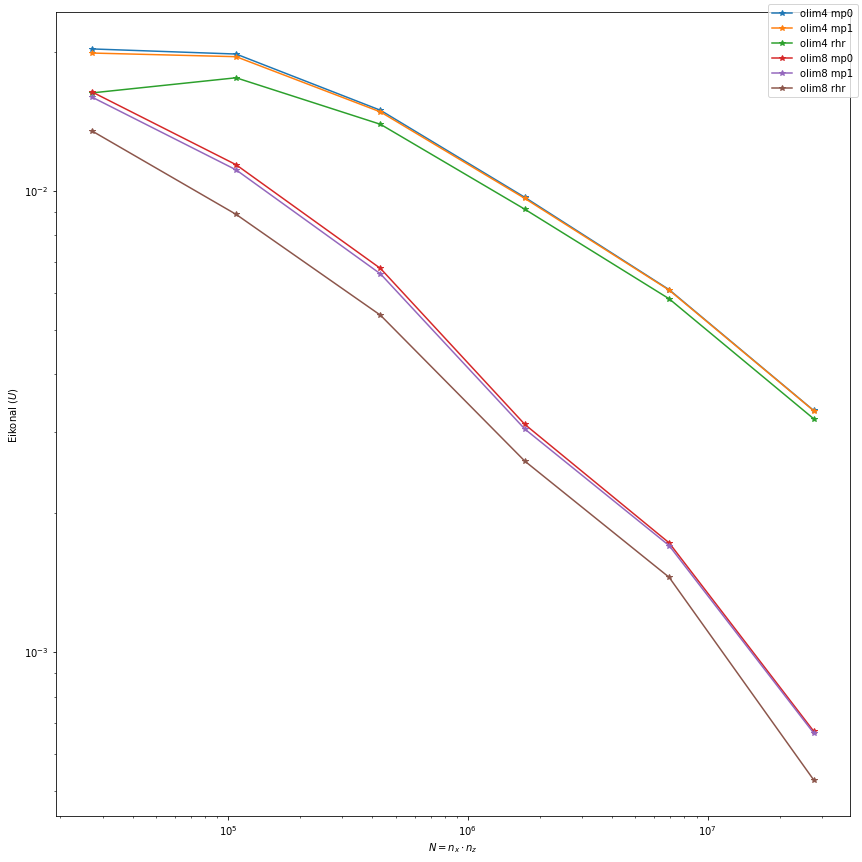

In [339]:
N = [u.size for u in us]
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
for nb, quad in it.product(nbs, quads):
    err = [
        np.linalg.norm(E[nb, quad, l].flatten(), np.inf)
        for l in range(len(us) - 1)
    ]
    ax.loglog(N[:-1], err, '*-', label='%s %s' % (nb2str[nb], quad2str[quad]))
ax.set_ylabel(r'Eikonal ($U$)')
ax.set_xlabel(r'$N = n_x \cdot n_z$')
fig.tight_layout()
fig.legend()

# Plot pointwise errors

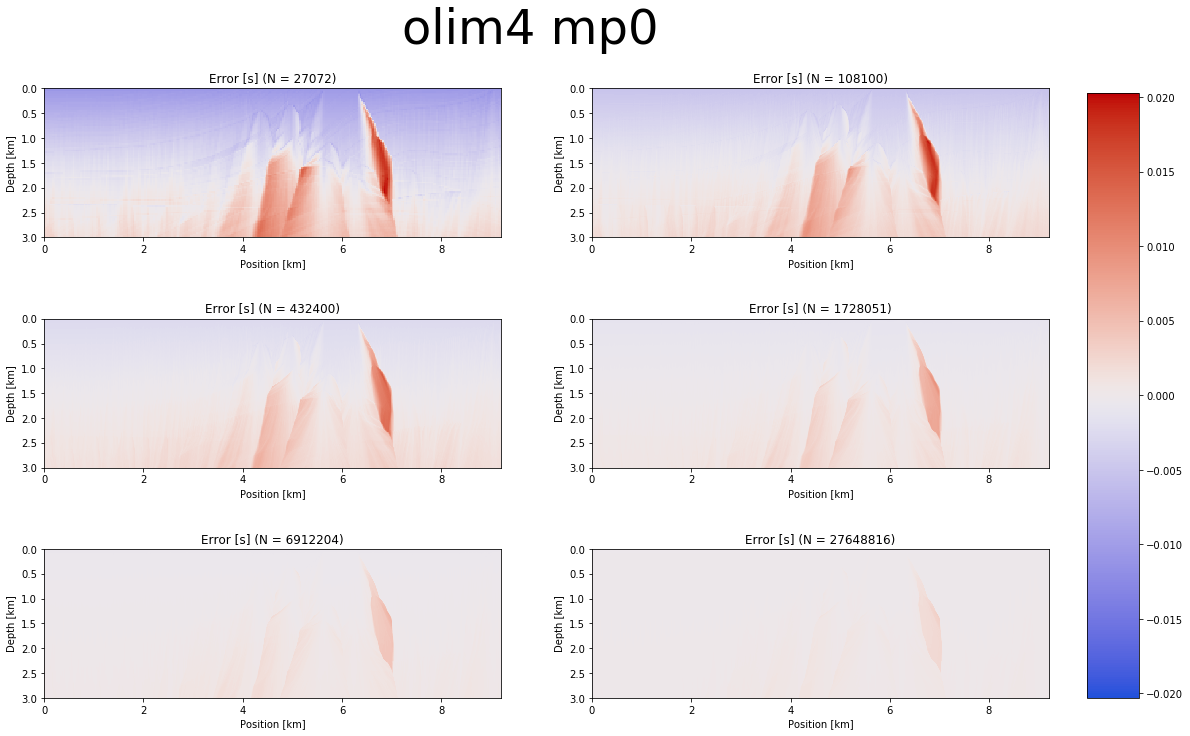

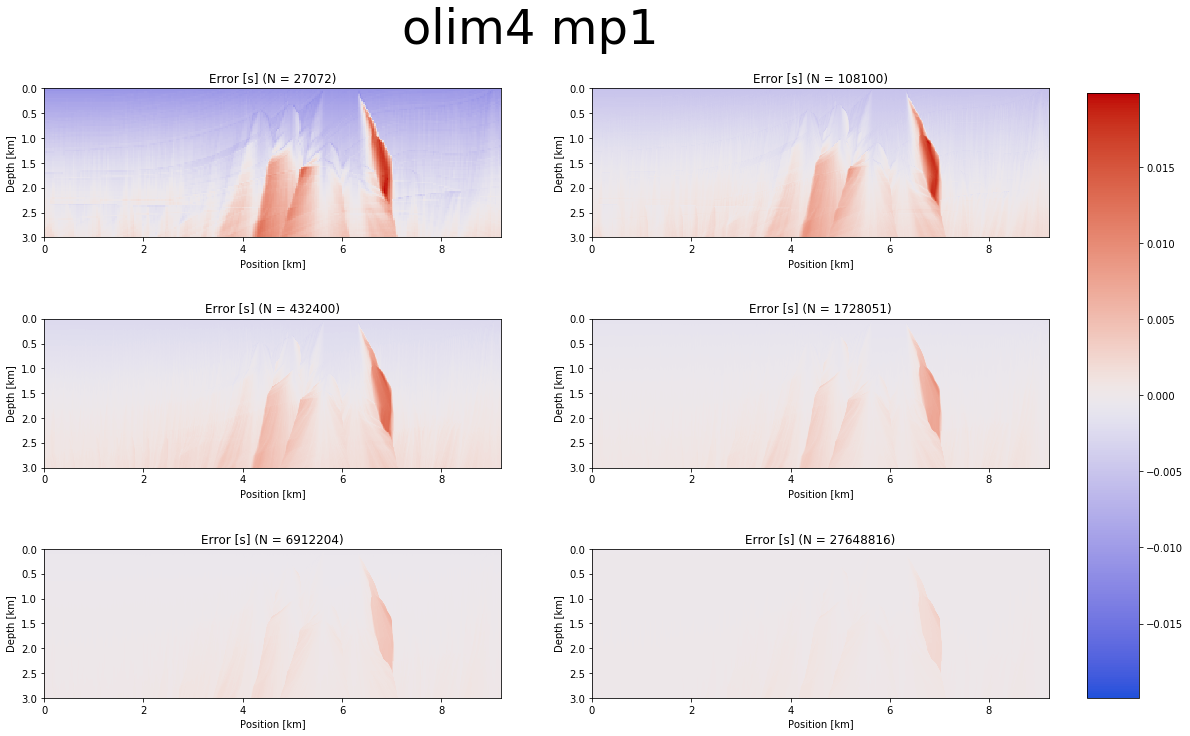

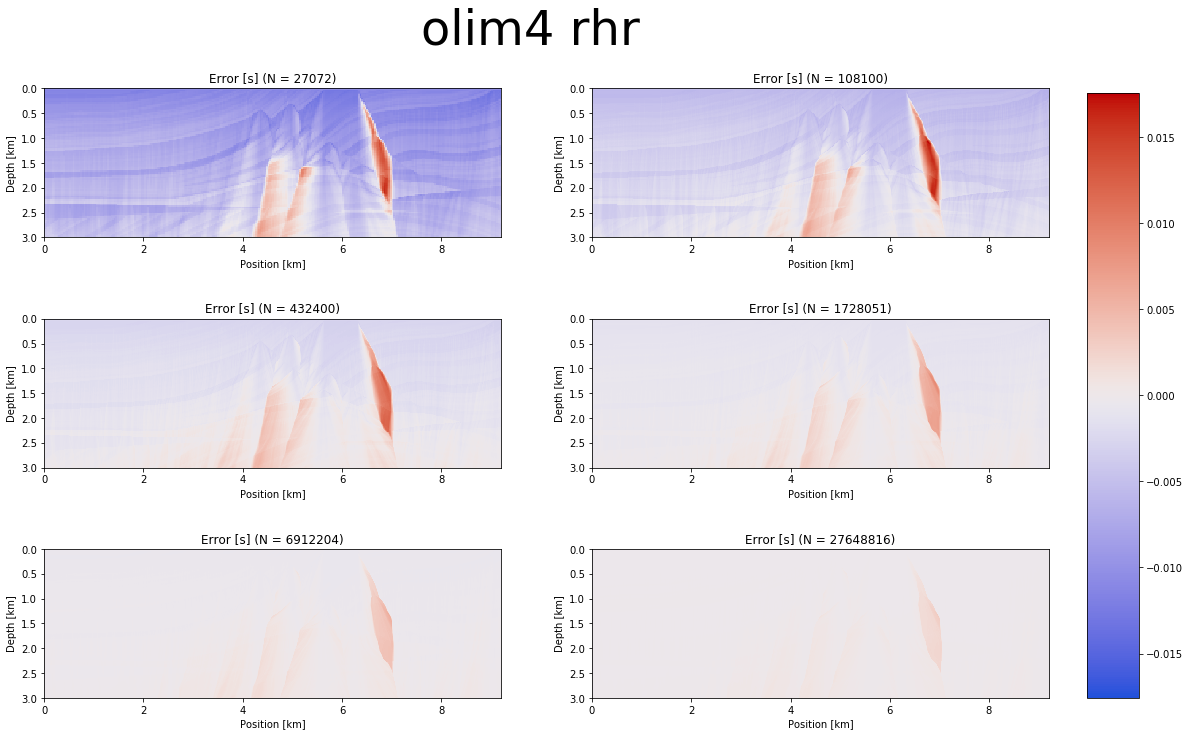

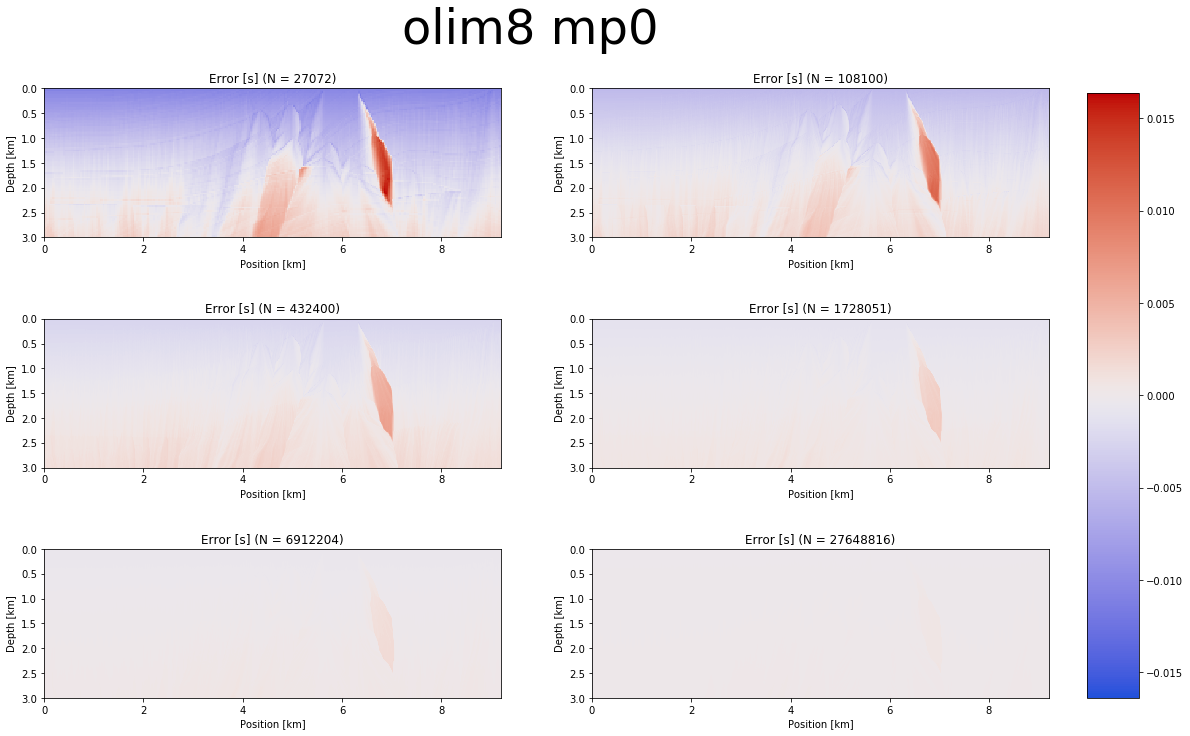

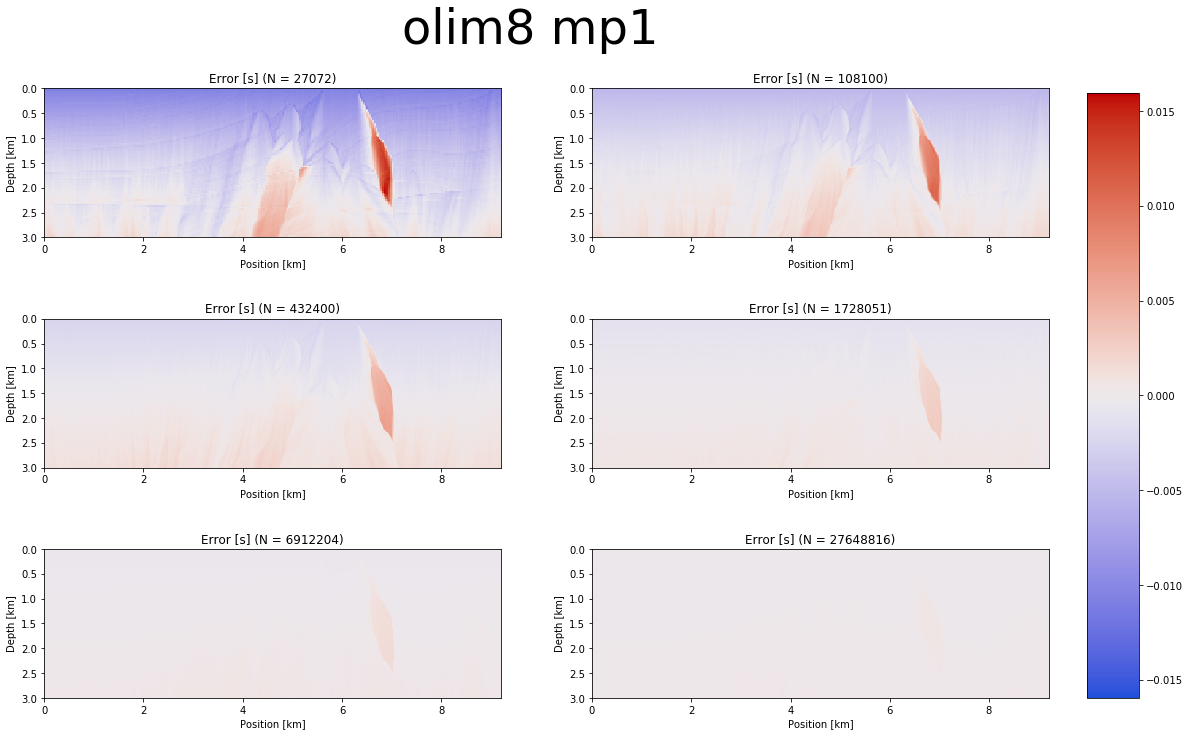

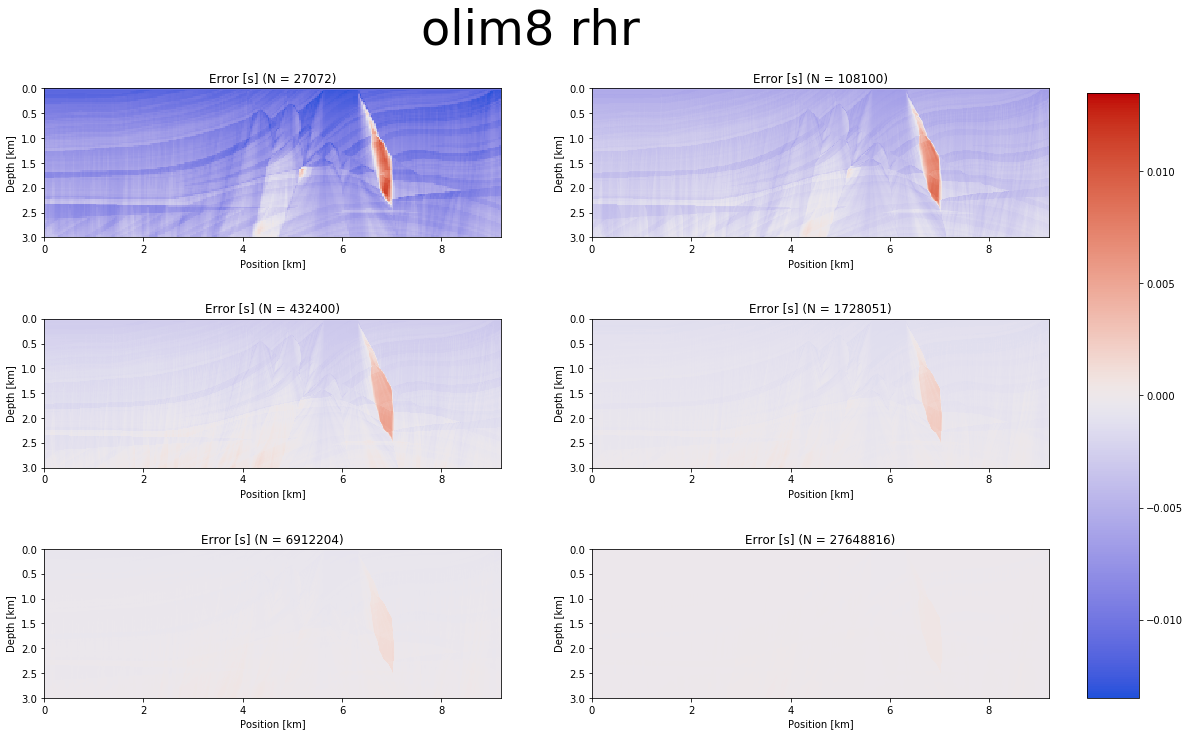

In [357]:
for nb, quad in it.product(nbs, quads):
    vmax = max(
        max(E[nb, quad, l].max(), -E[nb, quad, l].min())
        for l in range(6)
    )
    vmin = -vmax
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    for l, ax in zip(range(6), axes.flatten()):
        im = ax.imshow(E[nb, quad, l], cmap=cc.cm.coolwarm, vmax=vmax, vmin=vmin, extent=[xmin, xmax, zmax, zmin])
        ax.set_title('Error [s] (N = %d)' % N[l])
        ax.set_xlabel('Position [km]')
        ax.set_ylabel('Depth [km]')
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.04, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('%s %s' % (nb2str[nb], quad2str[quad]), y=0.95, fontsize=48)
    fig.show()